## My Neural Network

In [81]:
import numpy as np
import scipy as sc

import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

## Datasets

In [82]:
input_dataset = np.array([[0, 0]])
output_dataset = np.array([[1]])

## Activation functions

In [83]:
# function, derivate
sigm = lambda x : 1 / (1 + np.exp(-x))

sigmoid = (
    lambda x : sigm(x),
    lambda x : sigm(x) * (1 - sigm(x))
)

### Cost function

In [84]:
# function, derivate
mean_square_error = (
    lambda predictions, targets : np.mean((predictions - targets) ** 2),
    lambda predictions, targets : predictions - targets
)

def bin_cross_entropy(predictions, targets):
    return -np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))

cross_entropy = (
    lambda predictions, targets : bin_cross_entropy(predictions, targets),
    lambda predictions, targets : predictions - targets
)


## Neural Network Layer class

In [85]:
class NeuralLayer:
    def __init__(self, num_connections_entering, num_neurons, activation_fn, b, w):
        self.activation_fn = activation_fn
        
        # create from -1 to 1
        self.bias = b
        self.weights = w
        
        self.num_connections_entering = num_connections_entering
        self.num_neurons = num_neurons

# Neuronal Network

In [86]:
np.random.seed(10)

def create_neural_network():
    w1 = np.array([
        [ -5.12, 3.38],
        [-5.1, 3.37]
    ])
    b1 = np.array([
        [1.72, -5.25]
    ])
    w2 = np.array([
        [6.6],
        [6.5]
    ])
    b2 = np.array([
        [-3.2]
    ])
    neuralNetwork = [
        NeuralLayer(num_connections_entering=2, num_neurons=2, activation_fn=sigmoid, b=b1, w=w1),
        NeuralLayer(num_connections_entering=2, num_neurons=1, activation_fn=sigmoid, b=b2, w=w2),
    ]
    
    return neuralNetwork
    
XOR = create_neural_network()

def print_neural_network(neuralNetwork):
    list_indexes = list(range(neuralNetwork[0].num_connections_entering))
    inputs_names = list(map(lambda i: f"input {i + 1}", list_indexes))
    
    print(inputs_names, end="\n\n")
    
    for i, layer in enumerate(neuralNetwork):
        print(f"layer {i}: {layer.bias.shape[1]} neurons")
        print("weights")
        print(layer.weights, end="\n\n")
        print("bias")
        print(layer.bias, end="\n\n")
        
print_neural_network(XOR)

['input 1', 'input 2']

layer 0: 2 neurons
weights
[[-5.12  3.38]
 [-5.1   3.37]]

bias
[[ 1.72 -5.25]]

layer 1: 1 neurons
weights
[[6.6]
 [6.5]]

bias
[[-3.2]]



In [87]:
def foward_pass(neural_network, inputs, print_it=True):
    input_to_layer = inputs
    steps = [(None, inputs)]
    
    for _, layer in enumerate(neural_network):
        ponderate_sum = input_to_layer @ layer.weights + layer.bias
        input_to_layer = activation = layer.activation_fn[0](ponderate_sum)
        
        steps.append((ponderate_sum, activation))
    
    if print_it:
        prediction = np.hstack((inputs, input_to_layer))
        print("Current behavior")
        print(prediction, end="\n\n")
    
    return steps

steps = foward_pass(XOR, input_dataset)
print(steps[-2][1])

Current behavior
[[0.         0.         0.91920404]]

[[0.84812884 0.00522013]]


In [88]:
def backpropagation(neural_network, inputs, outputs, cost_function, show, learning_rate = 3.2):
    steps = foward_pass(neural_network, inputs, show)
    deltas = [None] * len(neural_network)
    
    next_layer_weights = None
    num_layers, num_inputs = len(neural_network), inputs.shape[0]

    for i in reversed(range(num_layers)):
        ponderate_sum, activation = steps[i + 1]
        _, activation_last_layer = steps[i]
        
        if i == num_layers - 1:
            cost_activation = -cost_function[1](activation, outputs)
        else:
            cost_activation = deltas[i + 1] @ next_layer_weights.T / num_inputs
            
        activation_ponderate = neural_network[i].activation_fn[1](ponderate_sum)
        deltas[i] = delta = cost_activation * activation_ponderate
        
        gradient_weights = (activation_last_layer.T @ delta) / num_inputs
        gradient_bias = np.mean(delta, axis=0, keepdims=True)
        
        next_layer_weights = neural_network[i].weights
        print(i)
        print(cost_activation)
        print(gradient_weights)
        print(gradient_bias)
        print()
        
        neural_network[i].bias -= learning_rate * gradient_bias
        neural_network[i].weights -= learning_rate * gradient_weights
        
    error = cost_function[0](steps[-1][1], outputs)
    print(error)
    return error

In [89]:
def show_step(neural_network, input_dataset, output_dataset, cost_function, show):
    error_before = backpropagation(neural_network, input_dataset, output_dataset, cost_function, show)
    print(f"current error = {error_before}")
    
    if show: 
        steps = foward_pass(neural_network, input_dataset, False)
        error_after = cost_function[0](steps[-1][1], output_dataset)
        
        print_neural_network(neural_network)
        
        print(f"new error = {error_after}")
        print(f"difference = {abs(error_before - error_after)}", end="\n\n")
        
    return error_before
        
x = show_step(XOR, input_dataset, output_dataset, cross_entropy, True)

Current behavior
[[0.         0.         0.91920404]]

1
[[0.08079596]]
[[5.08924151e-03]
 [3.13236377e-05]]
[[0.00600055]]

0
[[0.03950592 0.03900299]]
[[0. 0.]
 [0. 0.]]
[[0.00508861 0.00020254]]

0.08424715898736196
current error = 0.08424715898736196
['input 1', 'input 2']

layer 0: 2 neurons
weights
[[-5.12  3.38]
 [-5.1   3.37]]

bias
[[ 1.70371644 -5.25064812]]

layer 1: 1 neurons
weights
[[6.58371443]
 [6.49989976]]

bias
[[-3.21920177]]

new error = 0.08812124699428422
difference = 0.003874088006922266



In [10]:
errors = []

In [11]:
@interact_manual(times = (200, 4500))
def trainXOR(times):
    global errors
    for i in range(times):
        error = show_step(XOR, input_dataset, output_dataset, cross_entropy, False)
        errors.append(error)
        

interactive(children=(IntSlider(value=2350, description='times', max=4500, min=200), Button(description='Run I…

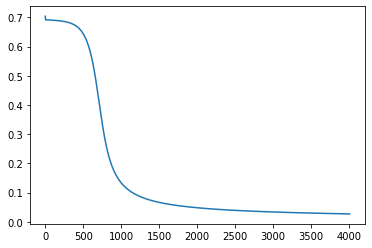

In [12]:
plt.plot(errors) 
plt.show() 

In [14]:
steps = foward_pass(XOR, input_dataset)
print_neural_network(XOR)

Current behavior
[[0.         0.         0.97246845]
 [0.         1.         0.03027662]
 [1.         0.         0.02493023]
 [1.         1.         0.9763505 ]]

['input 1', 'input 2']

layer 0: 2 neurons
weights
[[ 4.10048978  4.26678138]
 [-3.971267   -4.30274314]]

bias
[[ 2.04781403 -2.48145542]]

layer 1: 1 neurons
weights
[[ 10.35289971]
 [-10.77012401]]

bias
[[-4.77421887]]

